# Feature Importance 

Code which, given a trained model, calculates the importance of features on unseen data. We apply the Permutation Feature Importance technique. Inspired by https://scikit-learn.org/stable/modules/permutation_importance.html

In [8]:
import numpy as np 
import scipy as sp 
from sklearn.inspection import permutation_importance 

import tensorflow as tf 
import pandas as pd

import matplotlib.pyplot as plt 

We explicitly specify the loss function used to train the network. 

In [9]:
# Slight modification of the existing MSE metric used to evalutate the model training performance. 
# y_true - Tensorflow Tensor - actual time series 
# y_pred - Tensorflow Tensor - predicted time series. 
    
def mse_mod(y_true, y_pred):

    loss = K.mean(K.square(y_pred - y_true), axis=-1)
    loss_true = tf.reduce_mean(loss)
    
    # We add a small epsillion to the MSE. This makes it so that we avoid crazy losses
    return loss_true + 1e-8


Load the model 

In [10]:
full_model = 'fullModel_FebMar_7318'

loaded_model = tf.keras.models.load_model(f'models/{full_model}', custom_objects={'mse_mod':mse_mod})

Load the test data created during the model's training. 

In [11]:
import os 
import pickle as pkl 

#direc_name = f"dataset/OneMinResolution_OneHourWindow" # yaml worthy

with open(f'dataset/{full_model}_testData.pkl', 'rb') as f:
    X_test, y_test = pkl.load(f)

The permutation function isn't natively compatible with tensorflow, so we build our own! 

In [14]:
# permutes feature_index column of a given dataset X. We can permute multiple examples at once using the "num_examples" function
# X - multi-dimensional numpy array - input dataset
# num_examples - int - number of examples to corrupt
# feature_index - int - desired feature 

def data_corrupter(X, num_examples, feature_index):
    dark_X = np.copy(X)
    temp = dark_X
    shuffleInts = np.arange(720)
    np.random.shuffle(shuffleInts)
    if (len(feature_index)>1):
        dark_X[0:num_examples,:,feature_index] = dark_X[0:num_examples, shuffleInts[:,None], feature_index]
    else:
        dark_X[0:num_examples,:,feature_index] = dark_X[0:num_examples, shuffleInts, feature_index]
    return dark_X 

# Rather than permuting the feature_index column, we remove it entirely by "zero"ing it out. 
# X - multi-dimensional numpy array - input dataset
# num_examples - int - number of examples to corrupt
# feature_index - int - desired feature 

def data_subtractor(X, num_examples, feature_index):
    empty_X = np.copy(X)
    empty_X[0:num_examples,:,feature_index] = 0
    
    return empty_X

# Computes the root mean squared error between the true and predicted time series 
# y_true - actual time series
# y_pred - predicted time series

def rms(y_true, y_pred): 
    root_mean = np.sqrt((y_true - y_pred)**2)
    return root_mean 

# Computes the score of the model when corrupting the input dataset. We also consider pre-defined combinations of features permuted together
# model - Tensorflow Model - the loaded model 
# X - multi-dimensional array - the original input dataset 
# y - multi-dimensional array - time series 
# num_examples - int - number of examples
# num_repetitions - int - number of times to repeat excecuting the algorithm 
# permute - Boolean - do we enable the standard protocol, where we permute each feature column at random 
# subtract - Boolean - do we zero out the feature altogether from the final model 
# multiple - boolean - do we permute multiple features together? These are pre-defined in the function for now. 

def compute_score(model, X, y, num_examples, num_repetitions, permute=True, subtract=False, multiple=False):
    X_shape = np.shape(X)
    if (multiple): # (pressure, temp), (pressure, temp, wind speed), (pressure, temp, rel. humidity), (pressure, temp, relative humidity)
        num_of_features=[[2,3], [2,3,4], [2,3,0], [2,3,4,0]]
    else:
        num_of_features = np.arange(X_shape[-1])

    num_of_examples = X_shape[0]
    
    len_num_features = len(num_of_features)
    print(len_num_features)
    
    # Create a array that stores the scores for each feature and for each repetition of the algorithm 
    
    scores = np.zeros((len_num_features, num_repetitions))
    
    # Now let's make the model predict w/ corrupted data, and compute the score. 
    
    for ii, feat in enumerate(num_of_features):
        print(feat)
        for jj in range(num_repetitions): 
            print(jj)
            # Corrupt X. Either we permute the iith column, or we zero it out.
            if (permute):
                dark_X = data_corrupter(X, num_examples, feat)
            elif(subtract):
                dark_X = data_subtractor(X, num_examples, feat)
            #dark_X = data_corrupter(X, num_examples, ii)
            dark_X_extend = dark_X[0:num_examples,:,:]
            preds = model.predict(dark_X_extend, verbose=False)
            preds = np.array(preds)
            y_true = y[0:num_examples,:]
            # Compute the RMSE
            score = np.mean(rms(preds,y_true))
            scores[ii, jj] = score
            print(score)
    return scores


Compute the scores

In [ ]:
theScores = compute_score(loaded_model, X_test, y_test, 1000, 3, multiple=True)

This might take some time to compute. We save the values we got for future reference. 

In [9]:
np.savetxt('scores_1000_3_correlation', theScores)

NameError: name 'theScores' is not defined

If you've already done the calcs, load the score values. 

In [18]:
theScores = np.loadtxt('scores_1000_3')

The time is nigh to calculate the permutation importance 

In [19]:
# Computes the permutation feature importance for each feature 
# num_examples - number of examples 
# X - input dataset
# y - output time series 
# model - loaded model 
# scores - multi-dimensional array - model scores for each feature 

def compute_importance(num_examples, X, y, model, scores):
    X_shape = np.shape(X)
    num_of_features = X_shape[-1]
    num_of_examples = X_shape[0]
    
    # Start by computing the performance of the OG model
    
    light_X_extend = X[0:num_examples,:,:]
    preds = model.predict(light_X_extend, verbose=False)
    preds = np.array(preds)
    y_true = y[0:num_examples,:]
    
    # Compute the RMSE
    light_score = np.mean(rms(preds,y_true))
    print(light_score)
    
    # importance metrics
    importance_div = scores/light_score 
    importance_sub = scores - light_score 
    
    # Compute the mean and variance for each metric  
    importance_div_mean = np.mean(importance_div, axis=1)
    importance_div_var = np.var(importance_div, axis=1)
    
    importance_sub_mean = np.mean(importance_sub, axis=1)
    importance_sub_var = np.var(importance_sub, axis=1)
    
    print(f"Importance (division): {importance_div_mean}")
    print(f"Importance (subtraction): {importance_sub_mean}")
    
    return importance_div_mean, importance_div_var, importance_sub_mean, importance_sub_var
    
importance_div_mean, importance_div_var, importance_sub_mean, importance_sub_var = compute_importance(1000, X_test, y_test, loaded_model, theScores)

0.01345992188276089
Importance (division): [ 1.57991127  1.54690108  1.19086011  1.12718721  1.16555624  1.05697912
  3.21600449  3.59390868  1.00018941  0.99905523 10.83517168]
Importance (subtraction): [ 7.80556033e-03  7.36124584e-03  2.56896221e-03  1.71192988e-03
  2.22837403e-03  7.66934502e-04  2.98272473e-02  3.49138081e-02
  2.54943375e-06 -1.27165501e-05  1.32380643e-01]


bar plot the mean and variance of the PFI for each feature. 

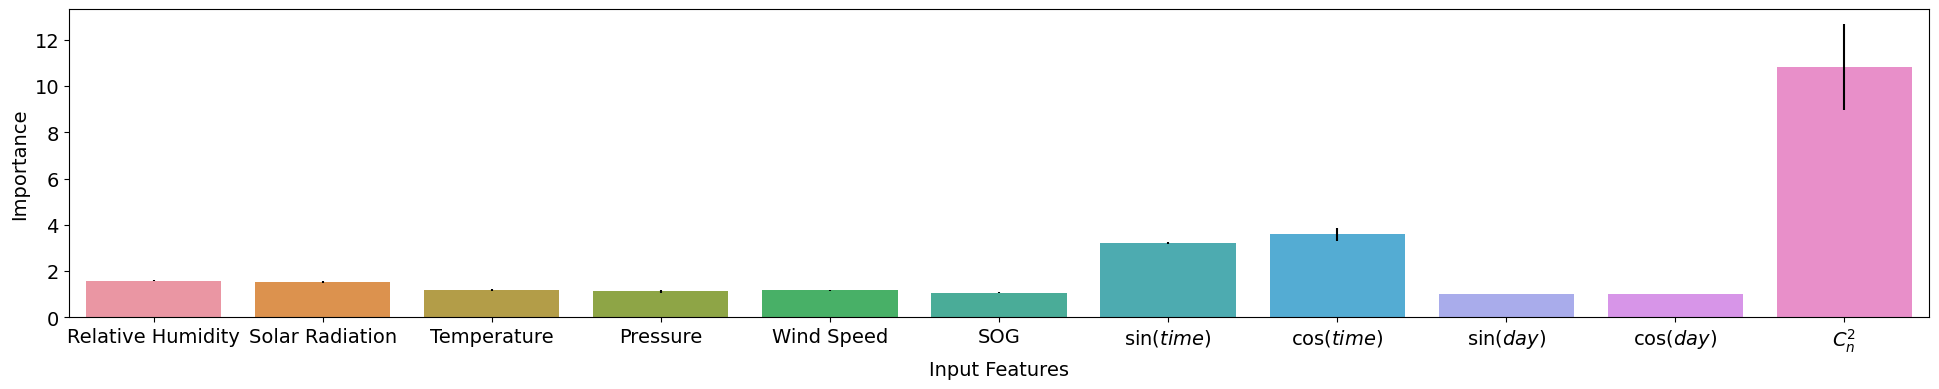

In [20]:
import seaborn as sns

input_features = ['Relative Humidity', 'Solar Radiation', 'Temperature', 'Pressure', 'Wind Speed', 'SOG', '$\sin(time)$', '$\cos(time)$', '$\sin(day)$', '$\cos(day)$', '$C_{n}^{2}$']
#input_features = ['Temperature & Pressure', 'Temperature, Pressure & Wind Speed', 'Temperature, Pressure & Relative Humidity', 'Temperature, Pressure, Relative Humidity & Wind Speed' ]

data = {
    
    'Input Features' : input_features,
    'Importance': importance_div_mean,
    'importance_var': np.sqrt(importance_div_var)
}

df = pd.DataFrame(data)
# Set font sizes
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

fig, ax = plt.subplots(figsize=(24,4))
# Set font sizes
ax=sns.barplot(x='Input Features', y='Importance', data=df, yerr=df['importance_var'])
#ax.set_xlabel(fontsize=22)
#plt.show()

save the bar plot 

In [70]:
plt.savefig('feature_importance.pdf', format='pdf', bbox_inches='tight')